# NEON Tables 
## Table2 : neon sites characteristics 

##### Author : Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)
##### Last revised: 2023-01-13
_______



In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import tqdm
from neon_utils import download_eval_files
import matplotlib.colors as colors
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
4 workers worked best for NEON.

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:41971,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


-------

In [4]:
# -- read list of sites:
#neon_sites_pft = pd.read_csv('/glade/scratch/negins/preprocessed_neon_csv_data/neon_sites_dompft.csv')
neon_sites_pft = pd.read_csv('/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/neon_sites_dompft.csv')
neon_sites = neon_sites_pft['Site'].to_list()


In [5]:
# neon_sites = ['BART']  # for testing
all_stats = []
all_sites = []
failed_sites = [] # -- list for saving failed sites
df_list =[]

years = ["2018","2019","2020","2021"]

for neon_site in tqdm.tqdm(neon_sites):
    try:
        #atm_dir = "/glade/work/negins/neon_scripts/notebooks/atm_files_2/"
        #atm_path = os.path.join(atm_dir, neon_site)
        atm_dir = "/glade/scratch/wwieder/NEON_testV2/"
        atm_suf = neon_site+".transient/run/inputdata/atm/cdeps/v2/"
        atm_path = os.path.join(atm_dir, atm_suf, neon_site)
        
        # Avoid reusing GPP results for missing sites
        # Won't use this now, but need to zero out GPP for NIWO and PUUM
        # this_df = []

        #read in preprocessed data from CLM simulations
        csv_dir = "/glade/scratch/wwieder/preprocessed_neon_v2/"
        csv_file = "preprocessed_"+neon_site+"*.csv"
        for f in glob((os.path.join(csv_dir, csv_file))):
            this_df = pd.read_csv(f)
        df_list.append(this_df)
        this_df['time'] = pd.to_datetime(this_df['time'],format= '%Y-%m-%d %H:%M:%S' )        

        atm_files = []

        for year in years:
             atm_files.extend(sorted(glob(join(atm_path,neon_site+"_atm_"+year+"*.nc"))))
                                          
        start = time.time()

        ds_atm = xr.open_mfdataset(atm_files, decode_times=True, combine='by_coords')

        end = time.time()        
        
        atm_vars = ['TBOT','PRECTmms']#,'RH','WIND','FSDS','FLDS']
        df = pd.DataFrame({'time':ds_atm.time})

        for var in atm_vars:
            field = np.ravel ( ds_atm[var])     
            df[var]=field
        
        # -- merge two pandas dataframe on time
        df=df.merge(this_df.set_index('time'), on='time', how='left')

        this_site = df.mean()
        all_stats.append(this_site)
        all_sites.append(neon_site)
            
    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass


 70%|███████   | 33/47 [03:53<01:07,  4.81s/it]

no files to open
THIS SITE FAILED: NIWO


100%|██████████| 47/47 [05:24<00:00,  6.90s/it]

no files to open
THIS SITE FAILED: PUUM


In [6]:
#this_df.time#.merge(this_df.set_index('time'), on='time', how='left')

In [7]:
df_all = (pd.concat(all_stats, axis = 1)).transpose()
df_all['site'] = all_sites
df_all = df_all.set_index('site')

Convert units for table
- MAT, K to C
- MAP, mm/s to mm/y
- GPP, gC/m2/d [calculated in preprocessing] to gC/m2/y

In [8]:
df_all['TBOT'] = np.around(df_all.TBOT-273.15,decimals=1)
df_all['PRECTmms'] = np.around(df_all.PRECTmms*3600*24*365,decimals=0)
df_all['sim_GPP'] = np.around(df_all.sim_GPP*365,decimals=0)
df_all = df_all[['TBOT','PRECTmms','sim_GPP']]    

In [9]:
out_dir = "/glade/work/wwieder/neon_vis_plots/paper_plots_final/"

if not os.path.exists (out_dir):
    os.mkdir(out_dir)
    
out_file = os.path.join(out_dir, 'table2.csv')
print ('saving table in ', out_file)

df_all.to_csv(out_file)

saving table in  /glade/work/wwieder/neon_vis_plots/paper_plots_final/table2.csv


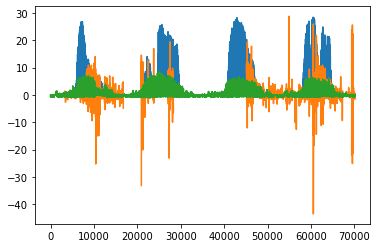

In [10]:
#(df.TBOT-273.15).plot(x='time')
df.sim_GPP.plot(x='time') ;
df.GPP.plot(x='time') ;
(df.Rnet/100).plot() ;


In [11]:
df_all

,TBOT,PRECTmms,sim_GPP
site,,,
BART,7.7,1213.0,1127.0
HARV,8.5,1405.0,1153.0
BLAN,13.1,1299.0,1400.0
SCBI,13.0,1159.0,1458.0
SERC,14.3,1193.0,1411.0
DSNY,22.6,1370.0,2808.0
JERC,20.0,1416.0,2674.0
OSBS,21.3,1419.0,2650.0
GUAN,26.3,558.0,622.0


In [12]:
neon_sites

['BART',
 'HARV',
 'BLAN',
 'SCBI',
 'SERC',
 'DSNY',
 'JERC',
 'OSBS',
 'GUAN',
 'LAJA',
 'STEI',
 'TREE',
 'UNDE',
 'KONA',
 'KONZ',
 'UKFS',
 'GRSM',
 'MLBS',
 'ORNL',
 'DELA',
 'LENO',
 'TALL',
 'DCFS',
 'NOGP',
 'WOOD',
 'CPER',
 'RMNP',
 'STER',
 'CLBJ',
 'OAES',
 'YELL',
 'MOAB',
 'NIWO',
 'JORN',
 'SRER',
 'ONAQ',
 'ABBY',
 'WREF',
 'SJER',
 'SOAP',
 'TEAK',
 'TOOL',
 'BARR',
 'BONA',
 'DEJU',
 'HEAL',
 'PUUM']